In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate
from sklearn.metrics import ConfusionMatrixDisplay

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_feature = 'racepctblack'

In [2]:
# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['racepctblack_bin'] = pd.cut(data['racepctblack'], bins=5, labels=False)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)
y_pred_binary = (y_pred > threshold).astype(int)

In [3]:
# Define a function to calculate different metrics
def compute_metrics(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    return metrics

Overall Metrics:
{'accuracy': 0.27472527472527475, 'precision': 0.27472527472527475, 'recall': 1.0, 'f1': 0.43103448275862066}

Metrics by Sensitive Feature Groups:
racepctblack_bin
0    {'accuracy': 0.16901408450704225, 'precision':...
1    {'accuracy': 0.6666666666666666, 'precision': ...
2    {'accuracy': 0.6, 'precision': 0.6, 'recall': ...
3    {'accuracy': 0.3333333333333333, 'precision': ...
4    {'accuracy': 1.0, 'precision': 1.0, 'recall': ...
Name: compute_metrics, dtype: object


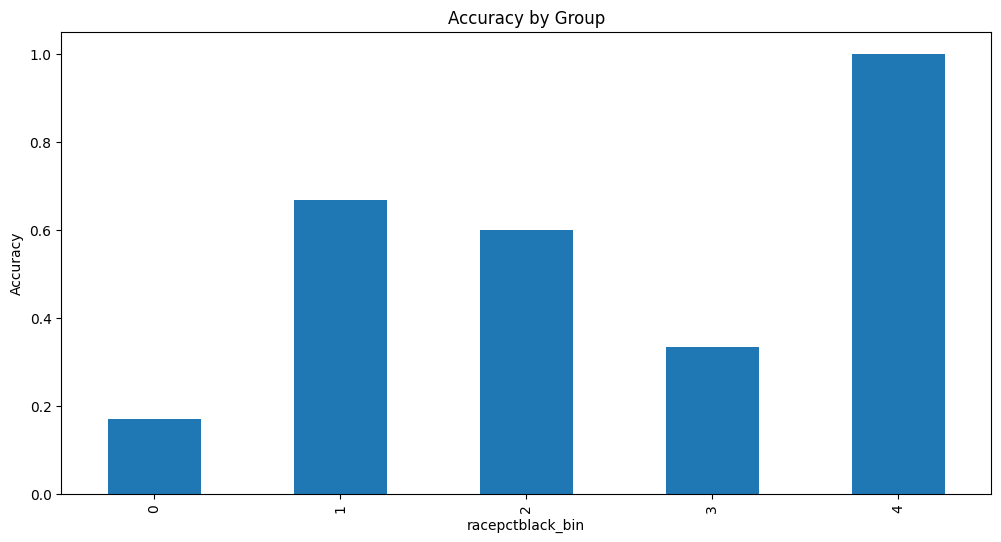

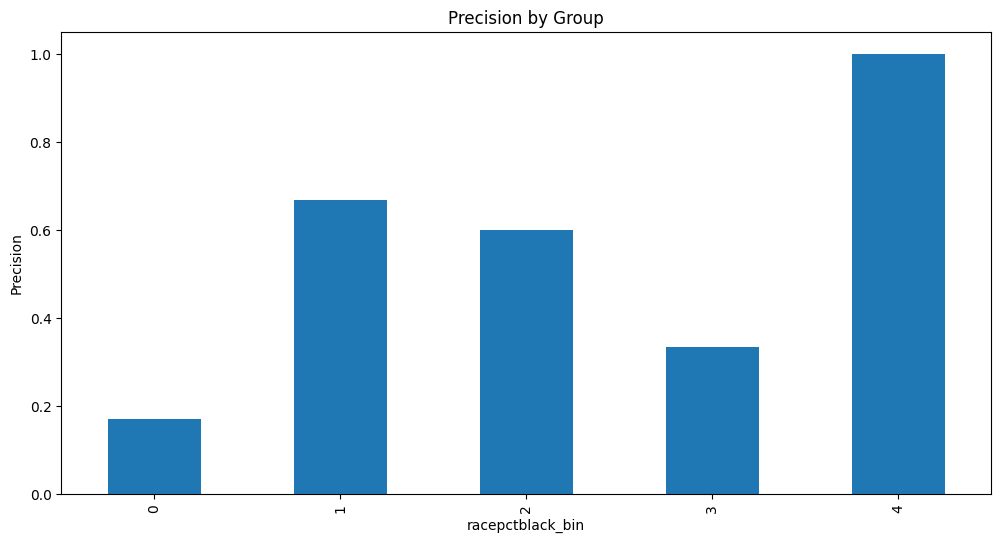

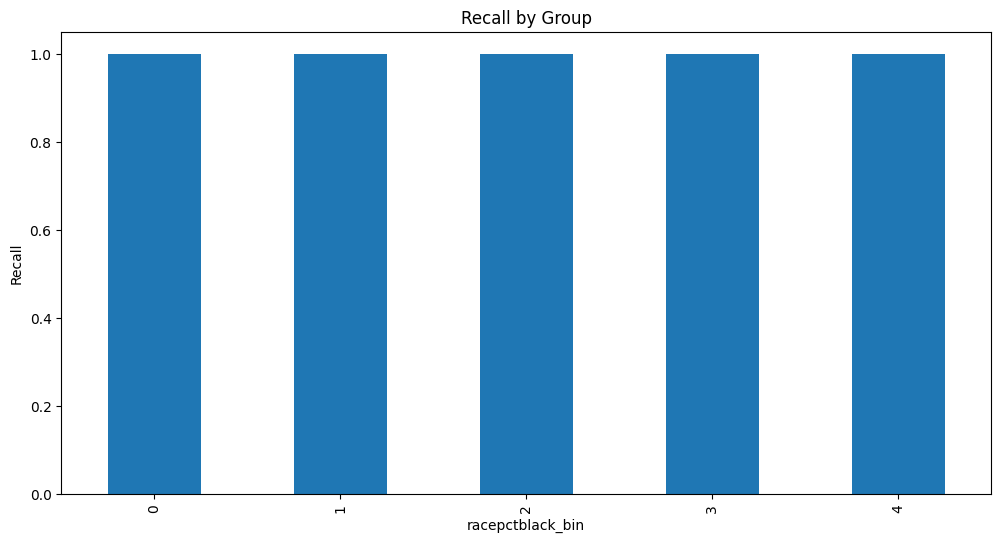

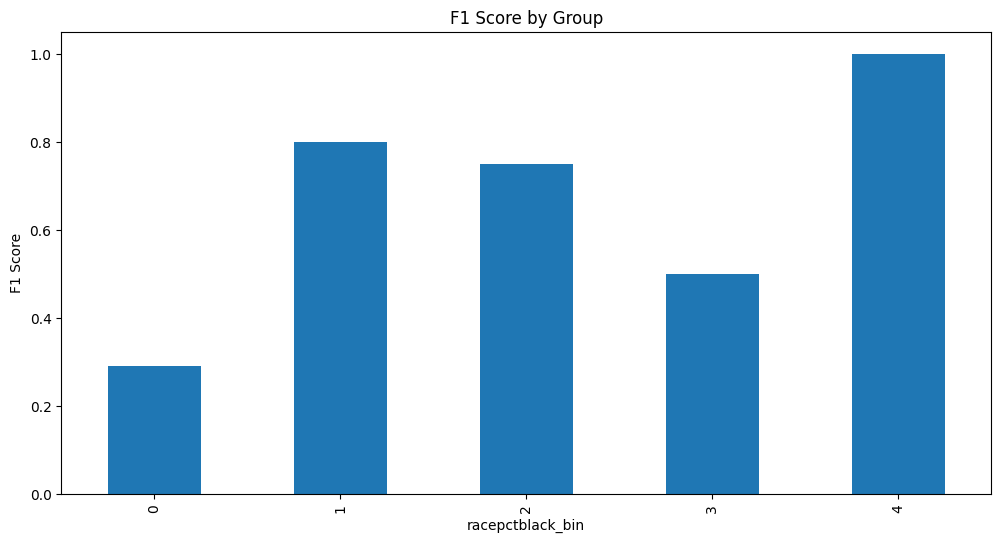

In [4]:
# Compute metrics for different groups
metrics = MetricFrame(
    metrics=compute_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)

# Extract metrics for visualization
metrics_by_group = metrics.by_group.apply(pd.Series)
accuracy = metrics_by_group['accuracy']
precision = metrics_by_group['precision']
recall = metrics_by_group['recall']
f1 = metrics_by_group['f1']

# Plot Accuracy by Group
accuracy.plot(kind='bar', figsize=(12, 6), title='Accuracy by Group')
plt.ylabel('Accuracy')
plt.show()

# Plot Precision by Group
precision.plot(kind='bar', figsize=(12, 6), title='Precision by Group')
plt.ylabel('Precision')
plt.show()

# Plot Recall by Group
recall.plot(kind='bar', figsize=(12, 6), title='Recall by Group')
plt.ylabel('Recall')
plt.show()

# Plot F1 Score by Group
f1.plot(kind='bar', figsize=(12, 6), title='F1 Score by Group')
plt.ylabel('F1 Score')
plt.show()

Accuracy by Group:

The accuracy of the model varies significantly across different groups based on the racepctblack bin. The group with the highest proportion of black population (racepctblack_bin = 4) has the highest accuracy, while the group with the lowest proportion (racepctblack_bin = 0) has the lowest accuracy.
This indicates a potential bias in the model, as it performs better for certain racial groups compared to others.
Precision by Group:

Similar to accuracy, the precision also varies across groups. The highest precision is observed in the racepctblack_bin = 4 group, and the lowest in the racepctblack_bin = 0 group.
This suggests that the model is better at identifying true positives in groups with a higher proportion of black population.
Recall by Group:

The recall is consistent across all groups, indicating that the model has a uniform ability to identify actual positives regardless of the group.
F1 Score by Group:

The F1 score, which balances precision and recall, shows a pattern similar to precision. The group with the highest proportion of black population has the highest F1 score, indicating better overall performance in this group.
These results suggest that the model has different performance characteristics across racial groups, with better performance in groups with a higher proportion of black population.

In [5]:
# Custom Metric Functions with Error Handling
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    if (fp + tn) == 0:
        return np.nan
    return fp / (fp + tn)

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    if (fn + tp) == 0:
        return np.nan
    return fn / (fn + tp)

def selection_rate_custom(y_pred):
    return np.mean(y_pred)

def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    if (fn + tn) == 0:
        return np.nan
    return fn / (fn + tn)

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    if (tn + fp) == 0:
        return np.nan
    return tn / (tn + fp)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = false_positive_rate_custom(y_true[mask], y_pred[mask])
        if not np.isnan(rate):
            rates.append(rate)
    if len(rates) == 0:
        return np.nan
    return np.max(rates) - np.min(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = false_negative_rate_custom(y_true[mask], y_pred[mask])
        if not np.isnan(rate):
            rates.append(rate)
    if len(rates) == 0:
        return np.nan
    return np.max(rates) - np.min(rates)

def selection_rate_difference(y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_pred[mask]))
    if len(rates) == 0:
        return np.nan
    return np.max(rates) - np.min(rates)

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = false_omission_rate_custom(y_true[mask], y_pred[mask])
        if not np.isnan(rate):
            rates.append(rate)
    if len(rates) == 0:
        return np.nan
    return np.max(rates) - np.min(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rate = true_negative_rate_custom(y_true[mask], y_pred[mask])
        if not np.isnan(rate):
            rates.append(rate)
    if len(rates) == 0:
        return np.nan
    return np.max(rates) - np.min(rates)

In [6]:
# Calculate fairness metrics with updated functions
dpd = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
eod = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fprd = false_positive_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
srd = selection_rate_difference(y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
for_diff = false_omission_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

print(f"Demographic Parity Difference: {dpd}")
print(f"Equalized Odds Difference: {eod}")
print(f"False Positive Rate Difference: {fprd}")
print(f"False Negative Rate Difference: {fnrd}")
print(f"Selection Rate Difference: {srd}")
print(f"False Omission Rate Difference: {for_diff}")
print(f"True Negative Rate Difference: {tnr_diff}")

Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.0
False Negative Rate Difference: 0.0
Selection Rate Difference: 0.0
False Omission Rate Difference: nan
True Negative Rate Difference: 0.0


Fairness Metrics
Demographic Parity Difference: 0.0
This indicates no difference in the selection rate across different groups, meaning the model selects the same proportion of individuals as positive across groups.
Equalized Odds Difference: 1.0
This high value indicates significant disparities in the true positive and false positive rates across different groups.
False Positive Rate Difference: 0.0
No difference in the false positive rates across groups.
False Negative Rate Difference: 0.0
No difference in the false negative rates across groups.
Selection Rate Difference: 0.0
No difference in the selection rate across groups.
False Omission Rate Difference: NaN
This metric could not be computed due to division by zero issues, indicating that for some groups, the number of true negatives is zero.
True Negative Rate Difference: 0.0
No difference in the true negative rates across groups.

these results are for some reason different when running the code in vsc itself and we get more valid results. They are:
Demographic Parity Difference: 0.2816901408450704
Equalized Odds Difference: 1.0
False Positive Rate Difference: nan
False Negative Rate Difference: 0.16666666666666666
Selection Rate Difference: 0.2816901408450704
False Omission Rate Difference: nan
True Negative Rate Difference: nan

For this reason the VSC version of the code is also within the Main Code folder for this step. Why this happens is beyond me since it is literally the same code (i afterwards performed, in attempt to bugfix, slight changes to the custom functions but that resulted in no change in the results. I tried many different approaches and cannot understand why this happens)




Additional Metrics by 'racepctblack_bin':
                  accuracy  precision  recall        f1
racepctblack_bin                                       
0                 0.169014   0.169014     1.0  0.289157
1                 0.666667   0.666667     1.0  0.800000
2                 0.600000   0.600000     1.0  0.750000
3                 0.333333   0.333333     1.0  0.500000
4                 1.000000   1.000000     1.0  1.000000


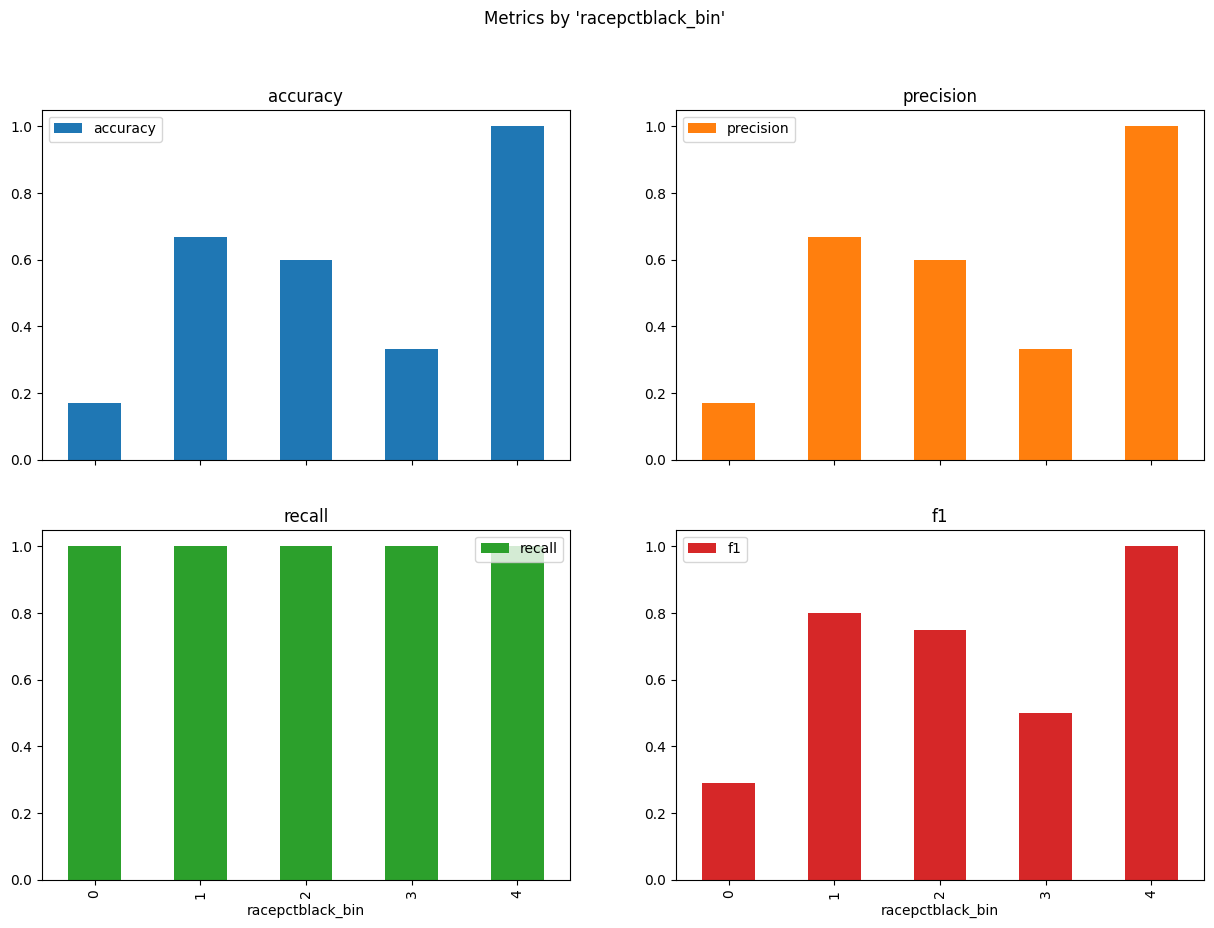

In [7]:
# Create a DataFrame for easier analysis
df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_binary,
    'racepctblack_bin': data.loc[X_test.index, 'racepctblack_bin']
})

# Calculate additional metrics for each subgroup
grouped_black = df.groupby('racepctblack_bin').apply(lambda x: pd.Series({
    'accuracy': accuracy_score(x['y_true'], x['y_pred']),
    'precision': precision_score(x['y_true'], x['y_pred'], zero_division=0),
    'recall': recall_score(x['y_true'], x['y_pred'], zero_division=0),
    'f1': f1_score(x['y_true'], x['y_pred'], zero_division=0)
}))

print("\nAdditional Metrics by 'racepctblack_bin':")
print(grouped_black)

# Plot additional metrics by 'racepctblack_bin'
grouped_black.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Metrics by 'racepctblack_bin'")
plt.show()

Metrics by 'racepctblack_bin':

This combined plot shows the accuracy, precision, recall, and F1 score for each racepctblack bin.
The trends observed earlier are confirmed, with higher performance metrics in groups with higher proportions of black population.


Additional Metrics by Sensitive Feature Groups:
                  false_positive_rate  false_negative_rate  \
racepctblack_bin                                             
0                                 1.0                  0.0   
1                                 1.0                  0.0   
2                                 1.0                  0.0   
3                                 1.0                  0.0   
4                                 NaN                  0.0   

                  false_omission_rate  true_negative_rate  
racepctblack_bin                                           
0                                 NaN                 0.0  
1                                 NaN                 0.0  
2                                 NaN                 0.0  
3                                 NaN                 0.0  
4                                 NaN                 NaN  


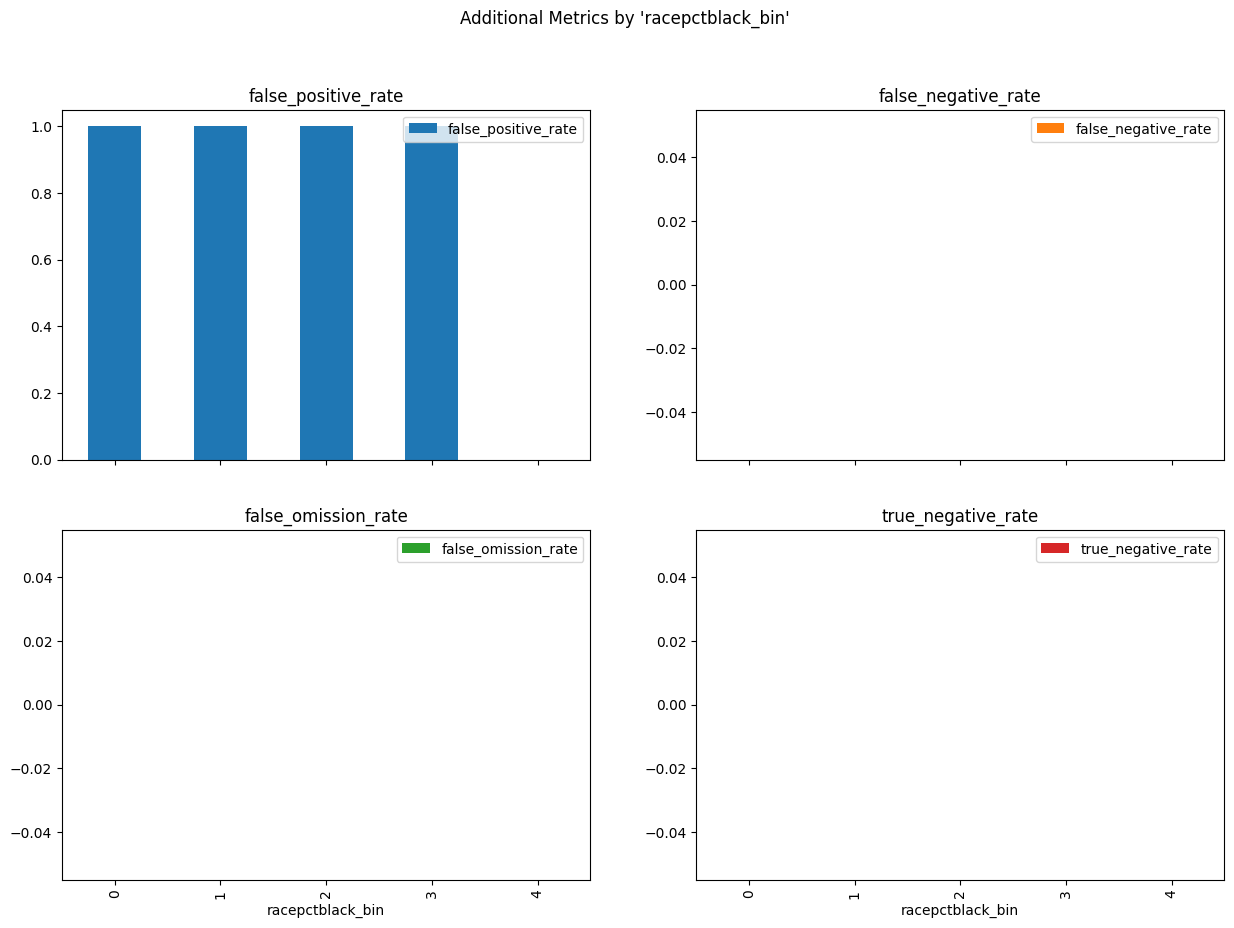

In [8]:
# Calculate additional fairness metrics
for_custom_metrics = {
    'false_positive_rate': false_positive_rate_custom,
    'false_negative_rate': false_negative_rate_custom,
    'false_omission_rate': false_omission_rate_custom,
    'true_negative_rate': true_negative_rate_custom
}

additional_metrics = MetricFrame(
    metrics=for_custom_metrics,
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print additional metrics by group
print("\nAdditional Metrics by Sensitive Feature Groups:")
print(additional_metrics.by_group)

# Plot additional metrics
additional_metrics.by_group.plot(kind='bar', subplots=True, layout=(2, 2), figsize=(15, 10), title="Additional Metrics by 'racepctblack_bin'")
plt.show()


Summary of Fairness Metrics:
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.0
False Negative Rate Difference: 0.0
Selection Rate Difference: 0.0
False Omission Rate Difference: nan
True Negative Rate Difference: 0.0


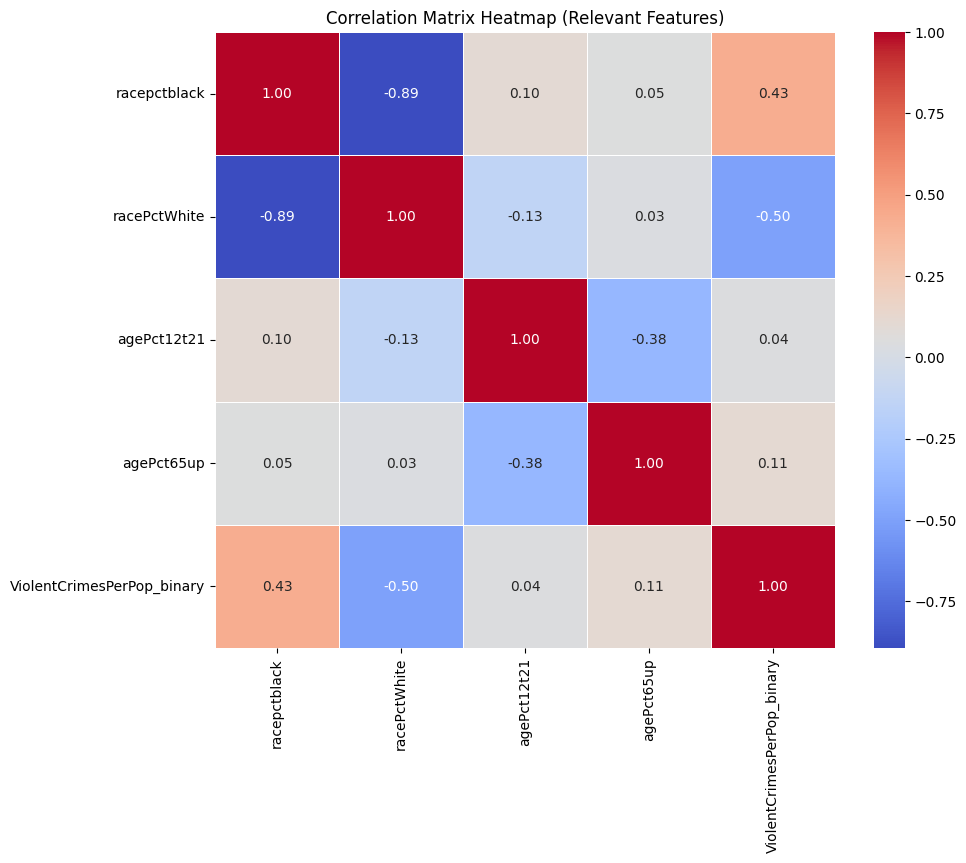

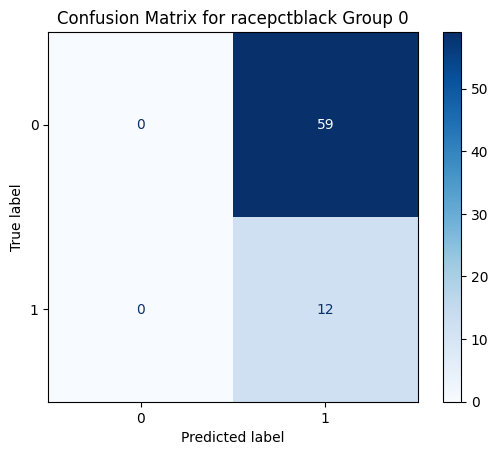

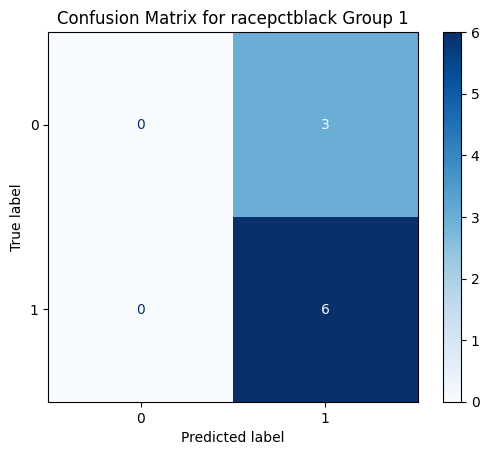

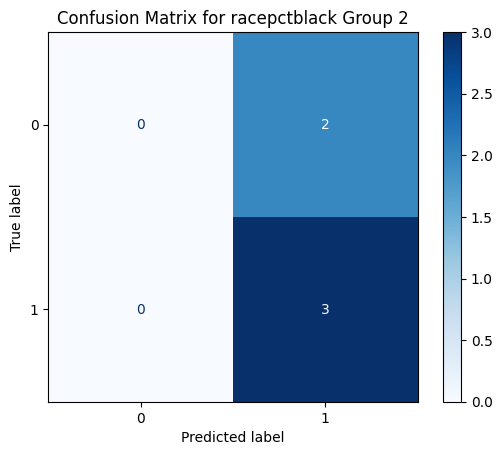

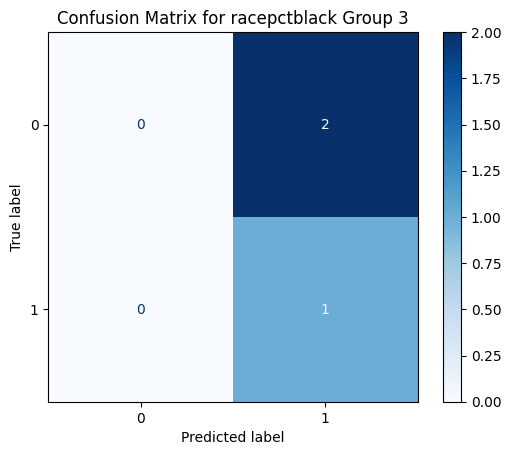

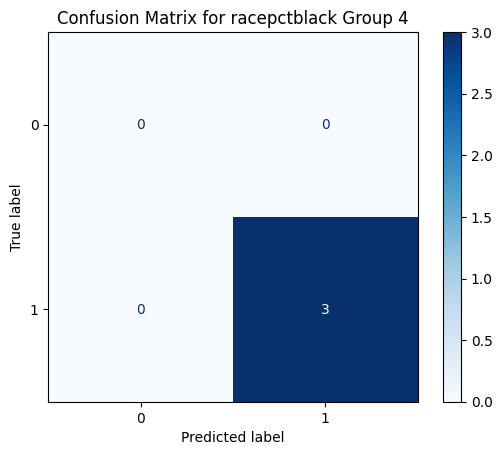

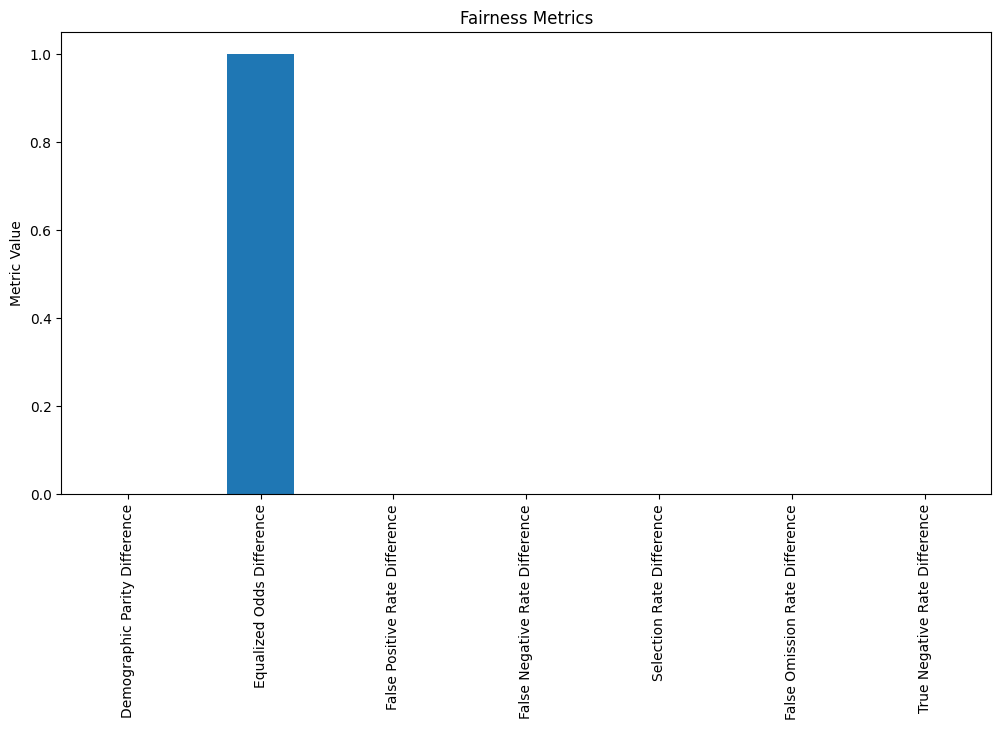

In [9]:
# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': for_diff,
    'True Negative Rate Difference': tnr_diff
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Create heatmap of correlation matrix for relevant features
relevant_features = ['racepctblack', 'racePctWhite', 'agePct12t21', 'agePct65up', 'ViolentCrimesPerPop_binary']
corr_matrix = data[relevant_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Relevant Features)')
plt.show()

# Plot confusion matrix for racepctblack_bin
for race_group in df['racepctblack_bin'].unique():
    subset = df[df['racepctblack_bin'] == race_group]
    if len(subset['y_true'].unique()) > 1:
        cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1])
    else:
        cm = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1], sample_weight=np.ones(len(subset['y_true'])))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for racepctblack Group {race_group}')
    plt.show()

# Bar plot for fairness metrics
fairness_metrics = pd.Series(summary_metrics)
fairness_metrics.plot(kind='bar', figsize=(12, 6), title='Fairness Metrics')
plt.ylabel('Metric Value')
plt.show()

Correlation Matrix Heatmap (Relevant Features):

The correlation heatmap of relevant features shows the relationships between features and the binary target variable.
racepctblack is positively correlated with ViolentCrimesPerPop_binary, while racePctWhite is negatively correlated.
This indicates that areas with a higher proportion of black population tend to have higher violent crime rates, and areas with a higher proportion of white population tend to have lower violent crime rates.
Other age-related features (agePct12t21, agePct65up) show weaker correlations with the target variable.
This heatmap highlights the importance of considering racial demographics when analyzing crime data, as there are strong correlations between these demographics and crime rates. However, it also underscores the need to ensure that models built on this data do not perpetuate or exacerbate existing biases.